In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Random Forest

# Read Data

In [155]:
#sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [156]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Deal with target value first

In [157]:
# here SalePrice is the target variable
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

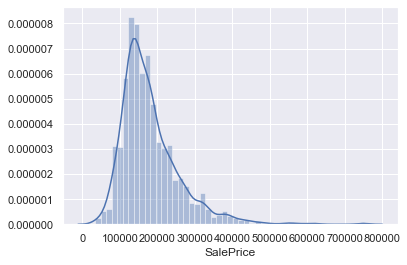

In [158]:
# draw a histogram 
sns.distplot(train['SalePrice'])

In [159]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


# Feature Selection

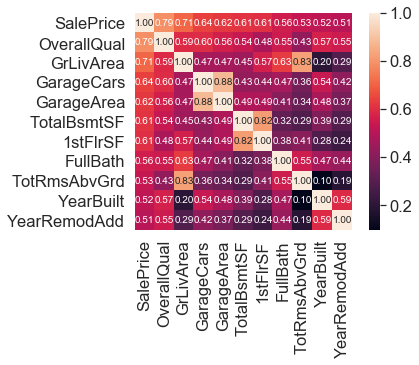

In [160]:
# correlation matrix
#saleprice correlation matrix
k = 11 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

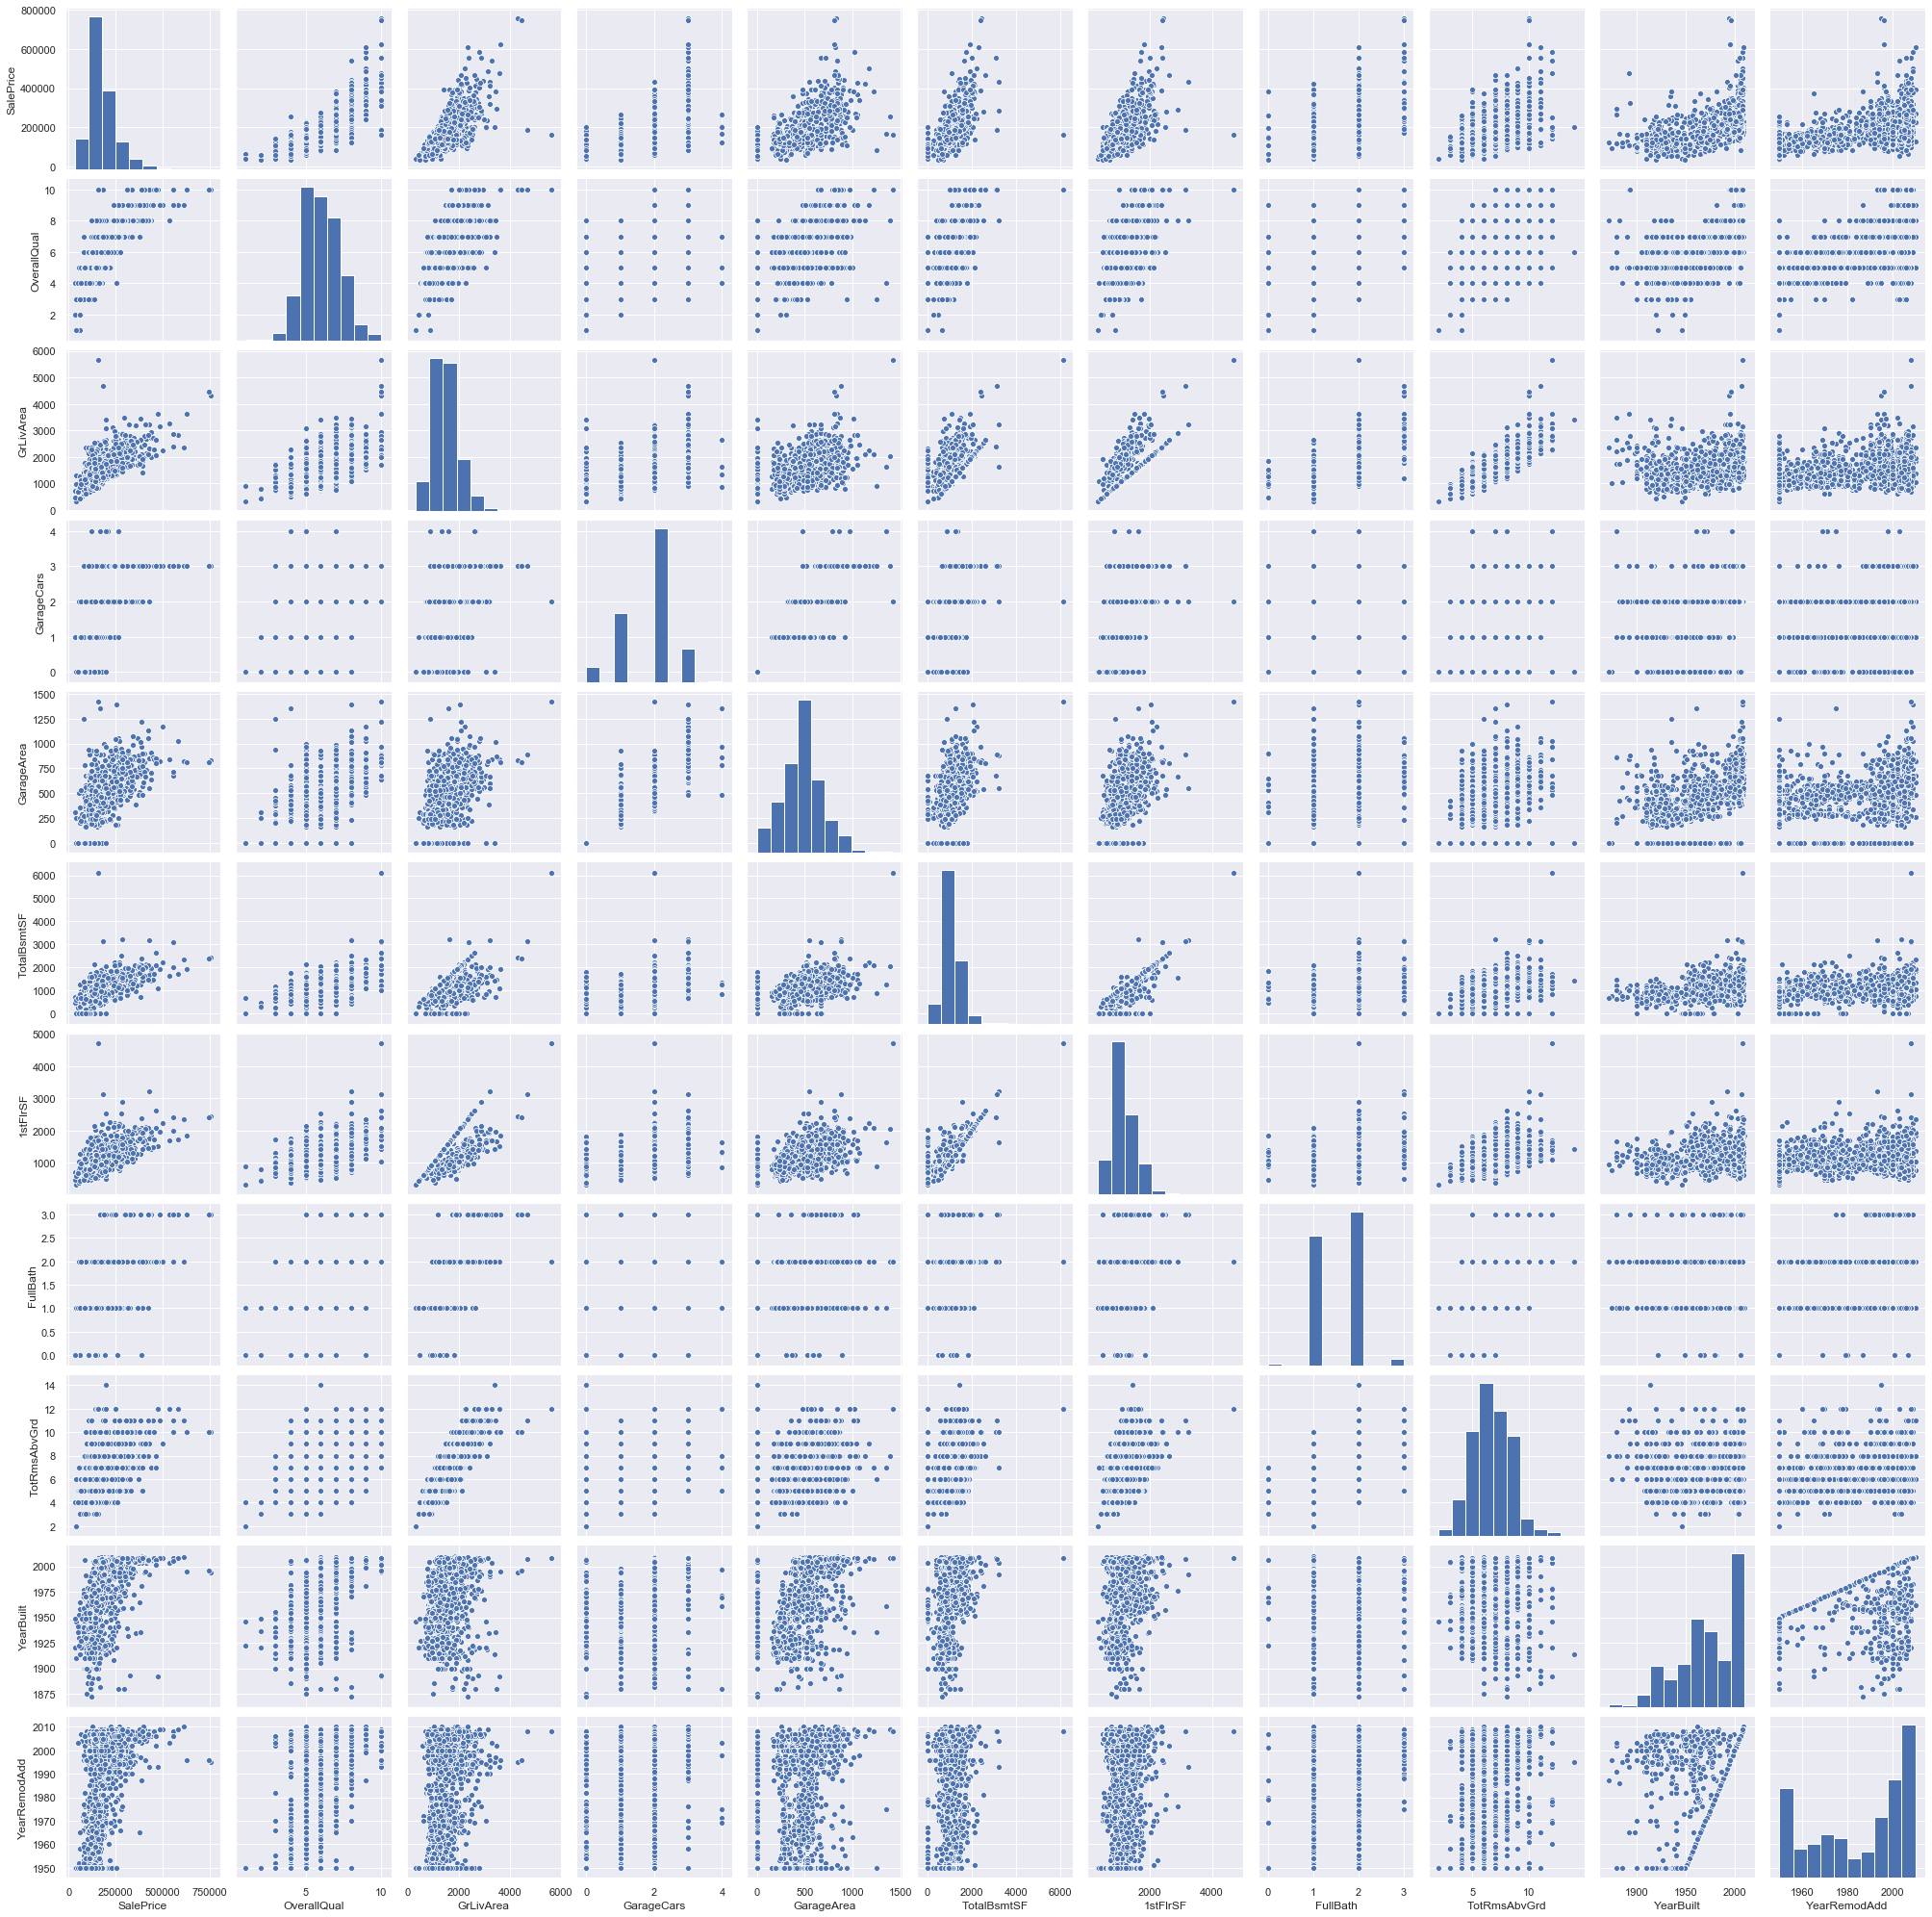

In [161]:
sns.set()
cols = ['SalePrice','OverallQual','GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF', '1stFlrSF','FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
sns.pairplot(train[cols], size = 2.5)
plt.show()

# Check Missing Data

In [162]:
cols = ['SalePrice','OverallQual','GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF', '1stFlrSF','FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
train[cols].isnull().sum()

SalePrice       0
OverallQual     0
GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [163]:
from sklearn import preprocessing
from sklearn import linear_model, svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

In [164]:
# 获取数据
cols = ['OverallQual','GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF', '1stFlrSF','FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
x = train[cols].values
y = train['SalePrice'].values
x_scaled = preprocessing.StandardScaler().fit_transform(x)
y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))
X_train,X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=42)

In [165]:
clfs = {
        'svm':svm.SVR(),
        'LinearRegression':linear_model.LinearRegression(),
        'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
        'BayesianRidge':linear_model.BayesianRidge()
       }
for clf in clfs:
    try:
        clfs[clf].fit(X_train, y_train)
        y_pred = clfs[clf].predict(X_test)
        print(clf + " cost:" + str(np.sum(y_pred-y_test)/len(y_pred)) )
    except Exception as e:
        print(clf + " Error:")
        print(str(e))

svm cost:-15.402022083676892
LinearRegression cost:-0.034882134316860165
RandomForestRegressor cost:-2.809573193213173
BayesianRidge cost:-16.811014753139858


Linear Regression seems to need the least cost

In [169]:
test_id = test['Id']

In [170]:
new_test = test[cols]
new_test.isnull().sum()

OverallQual     0
GrLivArea       0
GarageCars      1
GarageArea      1
TotalBsmtSF     1
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [176]:
new_test['GarageCars'] = new_test['GarageCars'].fillna(new_test['GarageCars'].mean())
new_test['GarageArea'] = new_test['GarageArea'].fillna(new_test['GarageArea'].mean())
new_test['TotalBsmtSF'] = new_test['TotalBsmtSF'].fillna(new_test['TotalBsmtSF'].mean())

In [177]:
new_test.isnull().sum()

OverallQual     0
GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [179]:
model=linear_model.LinearRegression()
model.fit(x,y)
y_pred = model.predict(new_test.values)
print(y_pred)

[110135.92110887 159059.96019542 169683.67729304 ... 156695.01584383
 111786.59984412 241008.24266205]


In [180]:
prediction = pd.DataFrame(Y_pred, columns=['SalePrice'])
result = pd.concat([test_id, prediction], axis=1)
result.to_csv('submission.csv', index=False)

# Lightgbm

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import norm, skew
from sklearn.preprocessing import PowerTransformer
import lightgbm as lgb

In [29]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [30]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## check data

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [32]:
# combine train and test data
data = pd.concat([train, test])
data.shape

(2919, 81)

In [33]:
# current categorical data
cat_cols = data.loc[:,data.dtypes == 'object'].columns
data.loc[:,cat_cols].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [34]:
# categorical data after conversion to one-hot vector
cat_data = pd.get_dummies(data.loc[:, cat_cols], drop_first=True)
cat_data.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [35]:
# current numeric data
numerics = data.loc[:,data.dtypes != 'object'].drop('Id', axis=1)
numerics.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,192,84,0,0,0,0,0,12,2008,250000.0


In [36]:
# numeric data after conversion to logarithm
log_numerics = np.log1p(numerics)
log_numerics.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,4.110874,4.189655,9.042040,2.079442,1.791759,7.602900,7.602900,5.283204,6.561031,0.0,...,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,1.098612,7.605392,12.247699
1,3.044522,4.394449,9.169623,1.945910,2.197225,7.589336,7.589336,0.000000,6.886532,0.0,...,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,1.791759,7.604894,12.109016
2,4.110874,4.234107,9.328212,2.079442,1.791759,7.601902,7.602401,5.093750,6.188264,0.0,...,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,2.302585,7.605392,12.317171
3,4.262680,4.110874,9.164401,2.079442,1.791759,7.557995,7.586296,0.000000,5.379897,0.0,...,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,1.098612,7.604396,11.849405
4,4.110874,4.442651,9.565284,2.197225,1.791759,7.601402,7.601402,5.860786,6.486161,0.0,...,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,2.564949,7.605392,12.429220


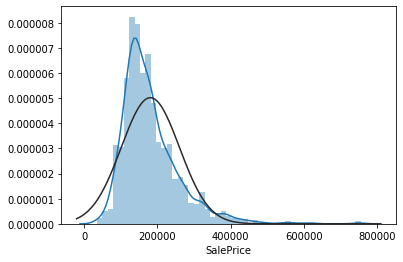

In [37]:
sns.distplot(numerics['SalePrice'],fit=norm)

#(mu, sigma) = norm.fit(train['SalePrice'])
#print("mu = {:.2f} and sigma = {:.2f}".format(mu,sigma))

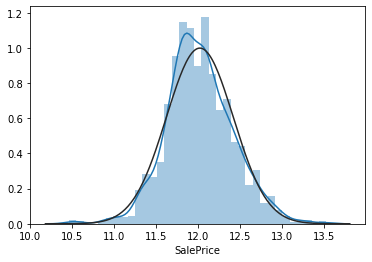

In [38]:
sns.distplot(log_numerics['SalePrice'],fit=norm)

In [39]:
# merge categorical and numeric columns
optimized_data = pd.concat([data['Id'], cat_data, log_numerics], axis=1)
optimized_data.head()

,Id,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,0,0,1,0,1,0,0,0,1,...,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,1.098612,7.605392,12.247699
1,2,0,0,1,0,1,0,0,0,1,...,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,1.791759,7.604894,12.109016
2,3,0,0,1,0,1,0,0,0,0,...,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,2.302585,7.605392,12.317171
3,4,0,0,1,0,1,0,0,0,0,...,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,1.098612,7.604396,11.849405
4,5,0,0,1,0,1,0,0,0,0,...,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,2.564949,7.605392,12.429220


In [40]:
for col in optimized_data.columns:
    optimized_data[col].fillna(optimized_data[col].mean(), inplace=True)
optimized_data.isnull().sum()

Id             0
MSZoning_FV    0
MSZoning_RH    0
MSZoning_RL    0
MSZoning_RM    0
              ..
PoolArea       0
MiscVal        0
MoSold         0
YrSold         0
SalePrice      0
Length: 247, dtype: int64

In [41]:
# split data into X_train, y_train and test
train = optimized_data[:train.shape[0]]
test_id = optimized_data[train.shape[0]:]['Id']
y_test = optimized_data[train.shape[0]:]['SalePrice']
test = optimized_data[train.shape[0]:].drop(['Id', 'SalePrice'], axis=1)
X_train = train.drop(['Id', 'SalePrice'], axis=1)
y_train = train['SalePrice']

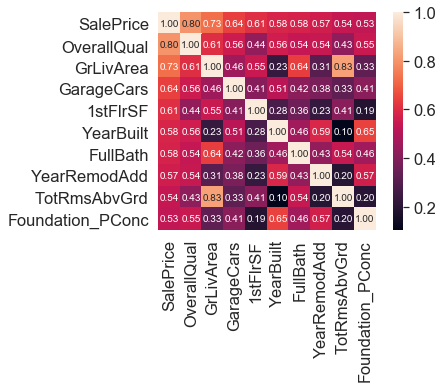

In [47]:
# correlation matrix
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
cols = ['SalePrice','OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
           

In [42]:
# train
lgb_train = lgb.Dataset(X_train, y_train)
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l2'},
        'num_leaves' : 40,
        'learning_rate' : 0.1,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : 0
}
gbm = lgb.train(params, lgb_train)
# predict
pred = gbm.predict(test)

In [43]:
# convert logarithms into exponent
pred = np.expm1(pred)
y_test = np.expm1(y_test)
# create submission file
results = pd.Series(pred, name='SalePrice')
submission = pd.concat([test_id, results], axis=1)
submission.to_csv('submission_lightgbm.csv', index=False)
submission.head()

,Id,SalePrice
0,1461,128258.038137
1,1462,158879.195831
2,1463,186705.682629
3,1464,184104.460556
4,1465,176855.834185


In [45]:
sum(abs(pred - y_test))/len(pred)

54440.050031928615